In [1]:
from pathlib import Path

import torch

from dynamic_fusion.network_trainer.configuration import TrainerConfiguration
from dynamic_fusion.network_trainer.network_loader import NetworkLoader


/home/davton/.local/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
checkpoints = [Path("../runs/ready/00_st-un_st-interp_st-up_16")]

In [3]:
checkpoint_dir = checkpoints[0]

config_path = checkpoint_dir / "config.json"
with config_path.open("r", encoding="utf8") as f:
    json_config = f.read()
# Parse the JSON string back into a Configuration instance
config = TrainerConfiguration.parse_raw(json_config)

config.network_loader.decoding_checkpoint_path = checkpoint_dir / "checkpoint_150000"
config.network_loader.encoding_checkpoint_path = checkpoint_dir / "checkpoint_150000"

device = torch.device("cuda")

encoder, decoder = NetworkLoader(config.network_loader, config.shared).run()
encoder = encoder.to(device)
decoder = decoder.to(device)

In [4]:
data_file = Path("../data/raw/e2vid/gun_bullet_gnome.txt")
lines = data_file.read_text()
lines_split = lines.split('\n')

In [8]:
dict = {'timestamp': [], 'x': [], 'y': [], 'polarity': []}

max_height = 320
max_width = 480

for line in lines_split[:len(lines_split)]:
    if len(line.split(' ')) == 4:
        t, x, y, p = line.split(' ')
        if (int(y) < max_height and int(x) < max_width):
            dict['timestamp'].append(float(t))
            dict['x'].append(int(x))
            dict['y'].append(int(y))
            dict['polarity'].append(int(p) > 0)
        
    if len(line.split(' ')) == 2:
        width, height = [int(x) for x in line.split(' ')]

width = width if max_width > width else max_width
height = height if max_height > height else max_height


In [9]:
import pandas as pd

events = pd.DataFrame(dict)

In [10]:
from dynamic_fusion.data_generator.configuration import EventDiscretizerConfiguration

bin_length = 0.02 # 20 ms
max_timestamp = events.timestamp.max() + (bin_length - events.timestamp.max() % bin_length)
number_of_temporal_bins = max_timestamp // bin_length

number_of_temporal_sub_bins_per_bin = 2
discretizer_config = EventDiscretizerConfiguration(number_of_temporal_bins=number_of_temporal_bins, number_of_temporal_sub_bins_per_bin=number_of_temporal_sub_bins_per_bin)

In [11]:
from dynamic_fusion.data_generator.event_discretizer import EventDiscretizer


discretizer = EventDiscretizer(discretizer_config, max_timestamp=max_timestamp)
discretized_events_dict = discretizer.run({1: events}, (height, width))
discretized_events = discretized_events_dict[1]

from dynamic_fusion.utils.dataset import discretized_events_to_tensors


event_polarity_sum, timestamp_mean, timestamp_std, event_count = discretized_events_to_tensors(discretized_events)
eps, means, stds, counts = event_polarity_sum.to(device)[None], timestamp_mean.to(device)[None], timestamp_std.to(device)[None], event_count.to(device)[None]

In [12]:
import queue
import time
import einops
import numpy as np
from skimage.transform import resize
import einops
from dynamic_fusion.utils.network import stack_and_maybe_unfold_c_list


from dynamic_fusion.utils.network import run_decoder, run_decoder_with_spatial_upscaling, to_numpy, unfold_temporally
from dynamic_fusion.utils.superresolution import get_spatial_upscaling_output, get_upscaling_pixel_indices_and_distances

with torch.no_grad():
    encoder.reset_states()
    output_shape = (height, width)
    nearest_pixels, start_to_end_vectors = get_upscaling_pixel_indices_and_distances(tuple(eps.shape[-2:]), output_shape)

    taus_to_evaluate = 5
    taus = np.arange(0, 1, 1 / taus_to_evaluate)
    taus = torch.tensor(taus).to(device)

    reconstructions = []

    # For unfolding, we need 3, for interpolation also, we need 4
    cs_queue = []


    reconstructions = []
    for t in range(int(number_of_temporal_bins) + 2):
        print(f'{t} / {number_of_temporal_bins + 2}', end = '\r')
        reconstructions_t = []
        if t < int(number_of_temporal_bins):
            c_t = encoder(
                eps[:, t], means[:, t] if config.shared.use_mean else None, stds[:, t] if config.shared.use_std else None, counts[:, t] if config.shared.use_count else None
            )
            cs_queue.append(stack_and_maybe_unfold_c_list([c_t], config.shared.spatial_unfolding)[0])

            if t == 0:
                # Makes code easier if we do it this way
                cs_queue.insert(0, torch.zeros_like(cs_queue[0]))

        
        if t > 1:
            # We usually have 4 items in the queue, near the end we have 3 or 2
            c_next = None
            if config.shared.temporal_unfolding:
                c = unfold_temporally(cs_queue, 1)
                if config.shared.temporal_interpolation and len(cs_queue) > 2:
                    c_next = unfold_temporally(cs_queue, 2)
            else:
                c = cs_queue[1] # B X Y C
                if config.shared.temporal_interpolation and len(cs_queue) > 2:
                    c_next = cs_queue[2]

            for i_tau in range(len(taus)):
                if config.shared.spatial_upscaling:
                    r_t = get_spatial_upscaling_output(decoder, c, taus[i_tau: i_tau + 1].to(c), c_next, nearest_pixels, start_to_end_vectors)
                else:
                    tau = einops.repeat(taus[i_tau: i_tau + 1].to(c), "1 -> T X Y 1", X=c.shape[-3], Y=c.shape[-2])
                    r_t = decoder(torch.concat([c, taus[t]], dim=-1))
                    if c_next is not None:
                        r_tnext = decoder(torch.concat([c_next, taus[t] - 1], dim=-1))
                        r_t = r_t * (1 - taus[t]) + r_tnext * (taus[t])

                reconstructions_t.append(to_numpy(r_t))


            reconstructions.append(np.stack(reconstructions_t, axis=0))

        if len(cs_queue) > 3:
            del cs_queue[0]

    reconstruction_stacked = np.stack(reconstructions, axis=0)  # T tau C X Y
    reconstrucion_flat = einops.rearrange(reconstruction_stacked, "tau T C D X Y -> (tau T) (C D) X Y")  # D=1
    


KeyboardInterrupt: 

In [13]:
from dynamic_fusion.utils.visualization import create_red_blue_cmap, img_to_colormap


colored_event_polarity_sums = img_to_colormap(to_numpy(eps.sum(dim=2)), create_red_blue_cmap(501))

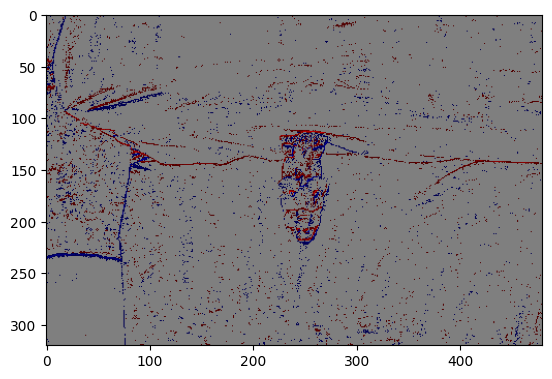

In [17]:
from matplotlib import pyplot as plt


plt.imshow(colored_event_polarity_sums[0,2])

In [11]:
eps.shape

torch.Size([1, 154, 2, 320, 480])

In [10]:
eps.shape

torch.Size([1, 154, 2, 320, 480])

In [ ]:
import cv2
size = tuple(reversed(reconstrucion_flat.shape[-2:]))
out = cv2.VideoWriter('output4.mp4', cv2.VideoWriter.fourcc(*'mp4v'), 10, size)
ms_per_frame = max_timestamp/(taus_to_evaluate*number_of_temporal_bins)*1000

font = cv2.FONT_HERSHEY_SIMPLEX
font_scale = 1
font_color = (255, 255, 255)  # White color
line_type = 2
position = (10, 50)  # Position of the text (bottom left corner)


for i, frame in enumerate(reconstrucion_flat):
    # Assuming frame is grayscale, you might need to ensure it's correctly shaped
    # If frame is 2D (grayscale), we need to convert it to 3D by adding an axis
    frame = frame[0, :, :, np.newaxis]

    # Flip vertically and rescale to 0-255
    frame_processed = (frame[::-1] * 255).astype(np.uint8)
    
    # If your frame is still grayscale, OpenCV expects a 3-channel image for color,
    # so if it's 1-channel (grayscale), you might convert it to BGR (or simply replicate the channels if it's okay to stay grayscale)
    if frame_processed.shape[2] == 1:
        frame_processed = cv2.cvtColor(frame_processed, cv2.COLOR_GRAY2BGR)
    
    i_event_frame = i // taus_to_evaluate

    cv2.putText(frame_processed, f"Frame={i_event_frame}, time={ms_per_frame*i:.0f} ms", position, font, font_scale, font_color, line_type)

    out.write(frame_processed)
out.release()


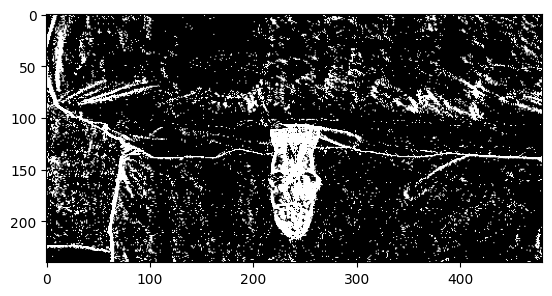

In [17]:
from matplotlib import pyplot as plt

plt.imshow(eps[0,8].abs().sum(dim=0).cpu(), cmap='gray', vmin=0, vmax=1)

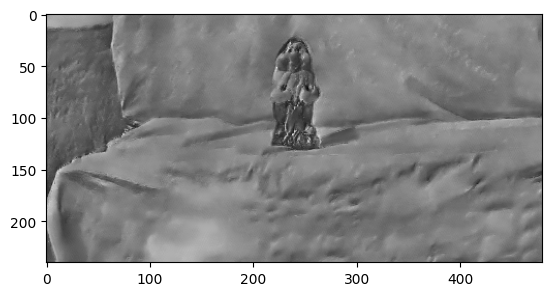

In [18]:
plt.imshow(reconstrucion_flat[8,0,::-1,:], cmap='gray')